<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Caso-de-estudio-1.1.2:-Análisis-de-la-LDA-(Latent-Dirichlet-Allocation)" data-toc-modified-id="Caso-de-estudio-1.1.2:-Análisis-de-la-LDA-(Latent-Dirichlet-Allocation)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Caso de estudio 1.1.2: Análisis de la LDA (Latent Dirichlet Allocation)</a></span></li><li><span><a href="#Generación-de-la-base-de-datos-(Web-Scraping)" data-toc-modified-id="Generación-de-la-base-de-datos-(Web-Scraping)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generación de la base de datos (Web Scraping)</a></span><ul class="toc-item"><li><span><a href="#Obtención-del-vocabulario" data-toc-modified-id="Obtención-del-vocabulario-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Obtención del vocabulario</a></span></li></ul></li><li><span><a href="#LDA-SVI" data-toc-modified-id="LDA-SVI-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LDA-SVI</a></span><ul class="toc-item"><li><span><a href="#Funciones-auxiliares" data-toc-modified-id="Funciones-auxiliares-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Funciones auxiliares</a></span><ul class="toc-item"><li><span><a href="#Importar-archivos" data-toc-modified-id="Importar-archivos-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Importar archivos</a></span></li><li><span><a href="#Generación-de-atributos-de-cada-texto-(recuento-de-palabras)" data-toc-modified-id="Generación-de-atributos-de-cada-texto-(recuento-de-palabras)-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Generación de atributos de cada texto (recuento de palabras)</a></span></li><li><span><a href="#Cálculo-de-distribuciones-de-probabilidad" data-toc-modified-id="Cálculo-de-distribuciones-de-probabilidad-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Cálculo de distribuciones de probabilidad</a></span></li></ul></li><li><span><a href="#Implementación-de-la-LDA-mediante-SVI" data-toc-modified-id="Implementación-de-la-LDA-mediante-SVI-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Implementación de la LDA mediante SVI</a></span></li></ul></li><li><span><a href="#Resultados" data-toc-modified-id="Resultados-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Resultados</a></span></li><li><span><a href="#Tarea-adicional" data-toc-modified-id="Tarea-adicional-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tarea adicional</a></span></li></ul></div>

# Caso de estudio 1.1.2: Análisis de la LDA (Latent Dirichlet Allocation)

Librerías a importar:

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import csv

from scipy.special import psi

#Web scraping libraries
from bs4 import BeautifulSoup

from tqdm.notebook import tqdm

#NLP libraries
import nltk
#run the first time you install nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize


# Generación de la base de datos (Web Scraping)

En primer lugar debemos obtener la lista de profesores del departamento de EECS, y el lab al que pertenecen. Para ello podemos usar librerías de _Web scraping_ como `BeautifulSoup`. Este tipo de librerías ofrecen funciones para explorar el código fuente de páginas web, y obtener información de su contenido. 

In [2]:
#Url de la lista de profesores de EECS
url_eecs_fac = 'https://www.eecs.mit.edu/people/faculty-advisors'
#Descargando el código fuente de dicha url
html_data = requests.get(url_eecs_fac).text
soup = BeautifulSoup(html_data, 'html.parser')
#Guardando el nombre y el laboratorio en dos listas
fac = [el.text for el in soup.find_all(class_ = 'field-content card-title')]
labs = []
for lab_raw in soup.find_all(class_ = 'views-field views-field-term-node-tid'):
    try:
        labs.append(lab_raw.find('a').text)
    except:
        labs.append('')
#Uniendo ambas listas y eliminando los profesores que no pertenencen a CSAIL, MTL, RLE o LIDS
fac_dept = list(zip(fac,labs))
fac_dept = [tup for tup in fac_dept if tup[1] in set(['CSAIL','MTL','RLE','LIDS'])]

print('Número de profesores de EECS: {}'.format(len(fac_dept)))
print(fac_dept[:5],'...')

Número de profesores de EECS: 165
[('Hal Abelson', 'CSAIL'), ('Elfar Adalsteinsson', 'RLE'), ('Anant Agarwal', 'CSAIL'), ('Pulkit Agrawal', 'CSAIL'), ('Akintunde Akinwande', 'MTL')] ...


En el guión se sugiere trabajar mediante archivos de texto `.txt`, de modo que podemos crear un nuevo directorio llamado `Data`, donde almacenaremos la información sobre artículos de investigación. En dicho directorio, crearemos un archivo denominado `alldocs.txt`, en el que escribiremos los nombres de archivo de cada artículo.

In [3]:
#Creating list of all docs ('alldocs.txt') in the desired directory
DATA_DIRECTORY = 'Data/'

with open(r"{}{}.txt".format(DATA_DIRECTORY,'alldocs'), "w") as f:
    pass    

Definimos una función para obtener todos los artículos de _arXiv_ de un autor determinado. También podemos definir una función que guarde la información del resumen de cada artículo (_abstract_), en un archivo `.txt`.

In [4]:
def save_abstract_to_txt(filename,content,directory=DATA_DIRECTORY):
    '''
    Creates a new .txt file and writing the abstract in it.
    Saves the title as a new line in the alldocs.txt file
    '''
    with open(r"{}{}.txt".format(directory,filename), "w") as f:
        print(content, file=f)
        
    with open(r"{}{}.txt".format(directory,'alldocs'), "a") as alldocs:
        alldocs.write(filename+'.txt\n')
        
def get_articles_for_author(author,save_abstracts = False):
    base_url = 'https://arxiv.org/search/?query=%22{name}%22&searchtype=author&abstracts=show&order=-announced_date_first&size=200'
    author_query_url = base_url.format(name= author.replace(' ','+'))
    query_result = requests.get(author_query_url).text
    soup = BeautifulSoup(query_result, 'html.parser')
    articles = soup.find_all(class_ = 'arxiv-result')
    #print('{} articles found for author = \"{}\"\n'.format(len(articles),author))

    #print('Parsing information from html arXiv source code: id, title, authors and abstract\n')
    ids = [el.find(class_ = 'list-title is-inline-block').find('a').text.strip('arXiv:') for el in articles]
    ids = [el.split('/')[1] if el.find('/')>=0 else el for el in ids]
    
    titles = [el.find(class_ = 'title is-5 mathjax').text.strip(' \n') for el in articles]
    authors = [[author.text for author in el.find(class_ = 'authors').find_all('a')] for el in articles]
    abstracts = [el.find(class_ = 'abstract-full has-text-grey-dark mathjax').text[9:-16] for el in articles]
    urls = [el.find(class_ = 'list-title is-inline-block').find('a')['href'] for el in articles]
    
    #Saving abstracts
    if save_abstracts:
        for i in range(len(articles)):
            save_abstract_to_txt(ids[i], abstracts[i])
    
    return ids, titles, authors, urls, abstracts

author = fac_dept[23][0]
print('Ejemplo de un artículo de {}: \n'.format(author))
ids, titles, authors, urls, abstracts = get_articles_for_author(author)
i = 0
print('arXiv ID: {} (url: {} )'.format(ids[i],urls[i]))
print('Título: {}'.format(titles[i]))
print('Autores: {}'.format(authors[i]))
print('---\n{}\n---'.format(abstracts[i]))

Ejemplo de un artículo de Tamara Broderick: 

arXiv ID: 1912.05516 (url: https://arxiv.org/abs/1912.05516 )
Título: More for less: Predicting and maximizing genetic variant discovery via Bayesian nonparametrics
Autores: ['Lorenzo Masoero', 'Federico Camerlenghi', 'Stefano Favaro', 'Tamara Broderick']
---
While the cost of sequencing genomes has decreased dramatically in recent years, this expense often remains non-trivial. Under a fixed budget, then, scientists face a natural trade-off between quantity and quality; they can spend resources to sequence a greater number of genomes (quantity) or spend resources to sequence genomes with increased accuracy (quality). Our goal is to find the optimal allocation of resources between quantity and quality. Optimizing resource allocation promises to reveal as many new variations in the genome as possible, and thus as many new scientific insights as possible. In this paper, we consider the common setting where scientists have already conducted a p

Una vez tenemos dicha función definida y hemos comprobado que funciona, podemos iterar la lista de profesores para obtener los artículos de cada profesor, y guardarlos en archivos `.txt`. 

In [5]:
ids = []
titles = []
authors = []
labs = []
EECS_facs = []
urls = []
abstracts = []
print('Descargando artículos de cada profesor:')
t0 = time.time()
for i,fac in enumerate(fac_dept):
    id_list, title_list, author_list, url_list, abstract_list  = get_articles_for_author(fac[0],save_abstracts= True)
    ids += id_list
    titles += title_list
    authors += author_list
    urls += url_list
    abstracts += abstract_list
    labs += [fac[1]]*len(id_list)
    EECS_facs += [fac[0]]*len(id_list)
    if round(i/10) == i/10:
        print('{}/{} autores'.format(i,len(fac_dept)))
tf = time.time()
print('{} artículos descargados en {:.2f}s'.format(len(ids),tf-t0))

Descargando artículos de cada profesor:
0/165 autores
10/165 autores
20/165 autores
30/165 autores
40/165 autores
50/165 autores
60/165 autores
70/165 autores
80/165 autores
90/165 autores
100/165 autores
110/165 autores
120/165 autores
130/165 autores
140/165 autores
150/165 autores
160/165 autores
2614 artículos descargados en 58.71s


Si en vez de trabajar con diferentes archivos `.txt`, quisiéramos guardar toda la información en una tabla de `pandas`, la siguiente celda muestra cómo hacerlo:

In [6]:
df = pd.DataFrame({'id':ids,'title':titles,'EECS_prof':EECS_facs,'lab':labs,'authors':authors,'url':urls,'abstract':abstracts})
df[['id','lab']] = df[['id','lab']].drop_duplicates()
df.head()

,id,title,EECS_prof,lab,authors,url,abstract
0,1910.03273,Joint multi-contrast Variational Network recon...,Elfar Adalsteinsson,RLE,"[Daniel Polak, Stephen Cauley, Berkin Bilgic, ...",https://arxiv.org/abs/1910.03273,Purpose: To improve the image quality of highl...
1,1909.13692,Nonlinear Dipole Inversion (NDI) enables Quant...,Elfar Adalsteinsson,RLE,"[Daniel Polak, Itthi Chatnuntawech, Jaeyeon Yo...",https://arxiv.org/abs/1909.13692,We propose Nonlinear Dipole Inversion (NDI) fo...
2,1907.04500,Fetal Pose Estimation in Volumetric MRI using ...,Elfar Adalsteinsson,RLE,"[Junshen Xu, Molin Zhang, Esra Abaci Turk, Lar...",https://arxiv.org/abs/1907.04500,The performance and diagnostic utility of magn...
3,1903.02959,Temporal Registration in Application to In-ute...,Elfar Adalsteinsson,RLE,"[Ruizhi Liao, Esra A. Turk, Miaomiao Zhang, Ji...",https://arxiv.org/abs/1903.02959,We present a robust method to correct for moti...
4,1608.03907,Temporal Registration in In-Utero Volumetric M...,Elfar Adalsteinsson,RLE,"[Ruizhi Liao, Esra Turk, Miaomiao Zhang, Jie L...",https://arxiv.org/abs/1608.03907,We present a robust method to correct for moti...


## Obtención del vocabulario 

Para poder utilizar las funciones proporcionadas en el guión del caso de estudio se necesita un archivo de vocabulario en formato `.csv`. Podemos obtenerlo del repositorio del estudio original de LDA SVI:

In [7]:
url = 'https://raw.githubusercontent.com/blei-lab/onlineldavb/master/dictnostops.txt'
vocab = pd.Series(requests.get(url).text.split('\n')[:-1])
vocab.to_csv('Data/dictionary.csv',header=False,index=False)

# LDA-SVI

## Funciones auxiliares

### Importar archivos

In [8]:
def get_filenames(filename):
    filenames = []
    with open(r"{}{}".format(DATA_DIRECTORY,filename), 'r') as f:
        docs = f.readlines()
        for doc in docs:
            filenames.append(str(doc).split("\n")[0])
    return filenames

def getfiles(filename):
    f = open(r"{}{}".format(DATA_DIRECTORY,filename), 'r')
    doc = f.read().split('\n')[0]
    return doc

def getalldocs(filename = None):
    files = get_filenames(filename)
    docs = []
    for file in files:
        doc = getfiles(file)
        docs.append(doc)
    return docs

def getVocab(file):
    '''getting vocab dictionary from a csv file (nostopwords)'''
    vocab = dict()
    with open(r"{}{}".format(DATA_DIRECTORY,file), 'r') as infile:
        reader = csv.reader(infile)
        for index, row in enumerate(reader):
            vocab[row[0]] = index

    return vocab

### Generación de atributos de cada texto (recuento de palabras)

In [9]:
def parseDocument(doc, vocab):
    wordslist = list()
    countslist = list()
    doc = doc.lower()
    tokens = wordpunct_tokenize(doc)

    dictionary = dict()
    for word in tokens:
        if word in vocab:
            wordtk = vocab[word]
            if wordtk not in dictionary:
                dictionary[wordtk] = 1
            else:
                dictionary[wordtk] += 1

    wordslist.append(list(dictionary.keys()))
    countslist.append(list(dictionary.values()))
    return (wordslist[0], countslist[0])

### Cálculo de distribuciones de probabilidad

In [10]:
def dirichlet_expectation(alpha):
    '''
    For a vector theta ~ Dir(alpha), computes E[log(theta)] given alpha.
    
    Taken from https://github.com/blei-lab/onlineldavb/blob/master/onlineldavb.py
    '''
    if (len(alpha.shape) == 1):
        return (psi(alpha) - psi(n.sum(alpha)))
    return (psi(alpha) - psi(n.sum(alpha, 1))[:, n.newaxis])

def beta_expectation(a, b, k):
    mysum = psi(a + b)
    Elog_a = psi(a) - mysum
    Elog_b = psi(b) - mysum
    Elog_beta = n.zeros(k)
    Elog_beta[0] = Elog_a[0]
    # print Elog_beta
    for i in range(1, k):
        Elog_beta[i] = Elog_a[i] + n.sum(Elog_b[0:i])
        # print Elog_beta
    # print Elog_beta
    return Elog_beta

def plottrace(x, Y, K, n, perp):
    for i in range(K):
        plt.plot(x, Y[i], label = "Topic %i" %(i+1))

    plt.xlabel("Number of Iterations")
    plt.ylabel("Probability of Each topic")
    plt.legend()
    plt.title("Trace plot for topic probabilities")
    plt.savefig("temp/plot_%i_%i_%f.png" %(K, n, perp))

## Implementación de la LDA mediante SVI

Obtenemos la implementación de LDA mediante SVI de las fuentes mencionadas en el guión:
* https://github.com/qlai/stochasticLDA
* https://github.com/blei-lab/onlineldavb

In [11]:
import sys, re, time, string, random, csv, argparse
import numpy as n
from scipy.special import psi
from nltk.tokenize import wordpunct_tokenize
#from utils import *
# import matplotlib.pyplot as plt

n.random.seed(10000001)
meanchangethresh = 1e-3
MAXITER = 10000

class SVILDA():
    """
        Arguments:
        K: Number of topics
        vocab: A set of words to recognize. When analyzing documents, any word
           not in this set will be ignored.
        D: Total number of documents in the population. For a fixed corpus,
           this is the size of the corpus. In the truly online setting, this
           can be an estimate of the maximum number of documents that
           could ever be seen.
        alpha: Hyperparameter for prior on weight vectors theta
        eta: Hyperparameter for prior on topics beta
        tau: A (positive) learning parameter that downweights early iterations
        kappa: Learning rate: exponential decay rate---should be between
             (0.5, 1.0] to guarantee asymptotic convergence.
        Note that if you pass the same set of D documents in every time and
        set kappa=0 this class can also be used to do batch VB.
    """
        
    def __init__(self, vocab, K, D, alpha, eta, tau, kappa, docs, iterations, parsed = False):
        self._vocab = vocab
        self._V = len(vocab)
        self._K = K
        self._D = D
        self._alpha = alpha
        self._eta = eta
        self._tau = tau
        self._kappa = kappa
        self._lambda = 1* n.random.gamma(100., 1./100., (self._K, self._V))
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)
        self._docs = docs
        self.ct = 0
        self._iterations = iterations
        self._parsed = parsed
        self._trace_lambda = {}
        for i in range(self._K):
            self._trace_lambda[i] = [self.computeProbabilities()[i]]
        self._x = [0]

    def updateLocal(self, doc): #word_dn is an indicator variable with dimension V
        (words, counts) = doc
        newdoc = []
        N_d = sum(counts)
        phi_d = n.zeros((self._K, N_d))
        gamma_d = n.random.gamma(100., 1./100., (self._K))
        Elogtheta_d = dirichlet_expectation(gamma_d)
        expElogtheta_d = n.exp(Elogtheta_d)
        for i, item in enumerate(counts):
            for j in range(item):
                newdoc.append(words[i])
        assert len(newdoc) == N_d, "error"

        for i in range(self._iterations):
            for m, word in enumerate(newdoc):
                phi_d[:, m] = n.multiply(expElogtheta_d, self._expElogbeta[:, word]) + 1e-100
                phi_d[:, m] = phi_d[:, m]/n.sum(phi_d[:, m])

            gamma_new = self._alpha + n.sum(phi_d, axis = 1)
            meanchange = n.mean(abs(gamma_d - gamma_new))
            if (meanchange < meanchangethresh):
                break

            gamma_d = gamma_new
            Elogtheta_d = dirichlet_expectation(gamma_d)
            expElogtheta_d = n.exp(Elogtheta_d)

        newdoc = n.asarray(newdoc)
        return phi_d, newdoc, gamma_d

    def updateGlobal(self, phi_d, doc):

        lambda_d = n.zeros((self._K, self._V))

        for k in range(self._K):
            phi_dk = n.zeros(self._V)
            for m, word in enumerate(doc):
                phi_dk[word] += phi_d[k][m] 
            lambda_d[k] = self._eta + self._D * phi_dk
        rho = (self.ct + self._tau) **(-self._kappa)
        self._lambda = (1-rho) * self._lambda + rho * lambda_d
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)

        if self.ct % 10 == 9:
            for i in range(self._K):
                self._trace_lambda[i].append(self.computeProbabilities()[i])
            self._x.append(self.ct)

    def runSVI(self):
        for i in tqdm(range(self._iterations)):
            randint = random.randint(0, self._D-1)
            #print("ITERATION", i, " running document number ", randint)
            if self._parsed == False:
                doc = parseDocument(self._docs[randint],self._vocab)
            phi_doc, newdoc, gamma_d = self.updateLocal(doc)
            self.updateGlobal(phi_doc, newdoc)
            self.ct += 1
                
    def computeProbabilities(self):
        prob_topics = n.sum(self._lambda, axis = 1)
        prob_topics = prob_topics/n.sum(prob_topics)
        return prob_topics

    def getTopics(self, docs = None):
        prob_topics = self.computeProbabilities()
        prob_words = n.sum(self._lambda, axis = 0)

        if docs == None:
            docs = self._docs
        results = n.zeros((len(docs), self._K))
        for i, doc in enumerate(docs):
            parseddoc = parseDocument(doc, self._vocab)

            for j in range(self._K):
                aux = [self._lambda[j][word]/prob_words[word] for word in parseddoc[0]]
                doc_probability = [n.log(aux[k]) * parseddoc[1][k] for k in range(len(aux))]
                results[i][j] = sum(doc_probability) + n.log(prob_topics[j])
        finalresults = n.zeros(len(docs))
        for k in range(len(docs)):
            finalresults[k] = n.argmax(results[k])
        return finalresults, prob_topics

    def calcPerplexity(self, docs = None):
        perplexity = 0.
        doclen = 0.
        if docs == None:
            docs =  self._docs
        for doc in docs:
            parseddoc = parseDocument(doc, self._vocab)
            _, newdoc, gamma_d = self.updateLocal(parseddoc)
            approx_mixture = n.dot(gamma_d, self._lambda)
            # print(n.shape(approx_mixture))
            approx_mixture = approx_mixture / n.sum(approx_mixture)
            log_doc_prob = 0.
            for word in newdoc:
                log_doc_prob += n.log(approx_mixture[word])
            perplexity += log_doc_prob
            doclen += len(newdoc)
            # print(perplexity, doclen)
        perplexity = n.exp( - perplexity / doclen)
        print(perplexity)
        return perplexity

    def plotTopics(self, perp):
        plottrace(self._x, self._trace_lambda, self._K, self._iterations, perp)

def test(k, iterations):

    docs = getalldocs("alldocs2.txt")
    vocab = getVocab("dictionary2.csv")
    
    testset = SVILDA(vocab = vocab, K = k, D = len(docs), alpha = 0.2,
                     eta = 0.2, tau = 1024, kappa = 0.7, docs = docs,
                     iterations= iterations)
    testset.runSVI()
    finallambda = testset._lambda

    heldoutdocs = getalldocs("testdocs.txt")
    perplexity = testset.calcPerplexity(docs = heldoutdocs)

    with open("temp/%i_%i_%f_results.csv" %(k, iterations, perplexity), "w+") as f:
        writer = csv.writer(f)
        for i in range(k):
            bestwords = sorted(range(len(finallambda[i])), key=lambda j:finallambda[i, j])
            bestwords.reverse()
            writer.writerow([i])
            for j, word in enumerate(bestwords):
                writer.writerow([word, vocab.keys()[vocab.values().index(word)]])
                if j >= 15:
                    break
    topics, topic_probs = testset.getTopics()
    testset.plotTopics(perplexity)

    for kk in range(0, len(finallambda)):
        lambdak = list(finallambda[kk, :])
        lambdak = lambdak / sum(lambdak)
        temp = zip(lambdak, range(0, len(lambdak)))
        temp = sorted(temp, key = lambda x: x[0], reverse=True)
        # print temp
        print('topic %d:' % (kk))
        # feel free to change the "53" here to whatever fits your screen nicely.
        for i in range(0, 10):
            print('%20s  \t---\t  %.4f' % (vocab.keys()[vocab.values().index(temp[i][1])], temp[i][0]))

    with open("temp/%i_%i_%f_raw.txt" %(k, iterations, perplexity), "w+") as f:
        # f.write(finallambda)
        for result in topics:
            f.write(str(result) + " \n")
        f.write(str(topic_probs) + " \n")

# Resultados

Una vez definidas todas las funciones necesarias sólo queda ejecutar el análisis de LDA:

In [17]:
mode = 'normal'
K = 5
alpha = 0.2
eta = 0.2
tau = 1024
kappa = 0.7
iterations = 100000
docs = "alldocs.txt"
vocab = "dictionary.csv"

if mode == "test":
    test(K, iterations)
if mode == "normal":
    assert vocab is not None, "no vocab"
    assert docs is not None, "no docs"
    docs = getalldocs(docs)
    D = len(docs)
    print('number of docs: {}'.format(D))
    vocab = getVocab(vocab)
    lda = SVILDA(vocab = vocab, K = K, D = D, alpha = alpha, 
                 eta = eta, tau = tau, kappa = kappa, docs = docs, 
                 iterations = iterations)
    lda.runSVI()
    lda

number of docs: 2614


Podemos observar las distribución de probabilidades de cada palabra del vocabulario con respecto a cada tema identificado en los textos:

In [18]:
lambda_df = pd.DataFrame({'word':list(vocab.keys())})
for i in range(K):
    lambda_df['Topic {}'.format(i+1)] = lda._lambda[i,:]
lambda_df

,word,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,writings,0.200000,0.200000,0.200000,0.200000,0.200000
1,yellow,0.200000,0.200000,0.200000,0.200000,0.200000
2,four,0.206940,44.977877,0.204583,0.202544,0.206400
3,woods,0.200000,0.200000,0.200000,0.200000,0.200000
4,hanging,0.200791,3.213850,0.200003,0.200003,0.200001
...,...,...,...,...,...,...
7697,upwards,0.201441,0.847169,0.200982,0.200405,0.201466
7698,ranks,0.209152,0.205151,0.206799,6.521945,0.204278
7699,indirectly,4.325375,0.201673,0.203538,2.406228,0.200626
7700,volumes,0.217598,0.200145,8.303690,0.205567,0.249232


Para entender cómo el algoritmo de LDA ha calculado la distribución de probabilidades de cada tema podemos observar las 10 palabras con mayor probabilidad por tema:

In [19]:
finalresults, prob_topics = lda.getTopics()

for column,prob in list(zip(lambda_df.columns[1:],prob_topics)):
    print('{} probability: {:.2f}%'.format(column,prob*100))
    print(lambda_df.nlargest(10, [column])[['word',column]],'\n')

Topic 1 probability: 68.85%
          word      Topic 1
6637     model  1133.612563
1884   problem  1063.990712
4605      show  1018.162066
493       time  1002.819152
3590     based   956.433807
2076   network   930.434894
2717  learning   842.337947
1067     paper   752.891165
1428   results   720.292113
4909       two   686.706542 

Topic 2 probability: 5.46%
           word     Topic 2
6351     states  122.381047
1538       high  114.570570
4909        two  114.543936
933        mass   94.501846
1646     system   92.395622
3486       mode   85.939200
7125  questions   81.693414
4218  materials   79.402431
524     current   78.098804
5640   material   63.787907 

Topic 3 probability: 4.39%
           word     Topic 3
5548       text  167.036181
310       logic   82.823291
4069    medical   78.734873
1994       word   64.431517
402       right   64.389738
941   reasoning   58.585576
3183    missing   56.564215
4222       left   55.461916
5231        big   54.268199
4064    regular   

Finalmente, también podemos observar cómo ha quedado la distribución de temas sobre el conjunto de los documentos descargados:

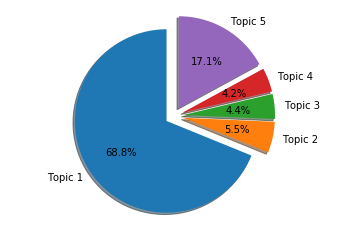

In [20]:
labels = lambda_df.columns[1:]
sizes = prob_topics*100
explode = (0.1, 0.1, 0.1,0.1, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Tarea adicional

Intentar reproducir el Gráfico 2 del guión del Caso de estudio 1.1.2, donde se analiza qué temas predominan en cada laboratorio.